# 5 — Summary similarity (compressibility)

This notebook computes **compressibility**-based statistics for *War and Peace* and *Anna Karenina*.
We use compression (zlib) to estimate redundancy and a normalized compression distance (NCD)
to measure similarity between the two books. The notebook follows the same project structure
as your other notebooks (auto-detects `data/` and `results/`, writes outputs to `results/sentiment_analysis/`).

**What you will get:**
- Compression ratio for each book (compressed size / original size).
- Normalized Compression Distance (NCD) between the two books.
- Distribution of compression ratios across fixed-size text segments (boxplot + histograms).
- Results saved as JSON and figures saved into `results/sentence_types/`.

⚠️ If you run this and see `ModuleNotFoundError` for packages like `nltk`, `matplotlib`, or `pandas`,
run `!pip install matplotlib pandas nltk` in a cell before executing this notebook.

In [1]:
import os
import re
import json
import zlib
from pathlib import Path
from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Optional: nltk for tokenization if needed later
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')


In [2]:
# Auto-detect project data/results directories (works if notebook is in notebooks/ or project root)
BASE_DIR = Path().resolve()
if (BASE_DIR / 'data').exists():
    DATA_DIR = BASE_DIR / 'data'
    RESULTS_DIR = BASE_DIR / 'results'
elif (BASE_DIR.parent / 'data').exists():
    DATA_DIR = BASE_DIR.parent / 'data'
    RESULTS_DIR = BASE_DIR.parent / 'results'
else:
    raise FileNotFoundError('Could not locate `data/` directory. Make sure your project structure is correct.')

OUT_DIR = RESULTS_DIR / 'sentence_types'
OUT_DIR.mkdir(parents=True, exist_ok=True)
print('DATA_DIR =', DATA_DIR)
print('OUT_DIR  =', OUT_DIR)

# Try to find War and Peace / Anna Karenina files in DATA_DIR by name heuristics
def find_book_file(data_dir, keywords):
    for p in data_dir.iterdir():
        if p.is_file():
            name = p.name.lower()
            if all(k.lower() in name for k in keywords):
                return p
    return None

war_file = find_book_file(DATA_DIR, ['war', 'peace'])
anna_file = find_book_file(DATA_DIR, ['anna', 'karen'])

if war_file is None:
    raise FileNotFoundError('Could not find War and Peace file in data directory: ' + str(DATA_DIR))
if anna_file is None:
    raise FileNotFoundError('Could not find Anna Karenina file in data directory: ' + str(DATA_DIR))

print('War file:', war_file.name)
print('Anna file:', anna_file.name)


DATA_DIR = C:\Users\Omen\Documents\GitHub\Fourth-Project\data
OUT_DIR  = C:\Users\Omen\Documents\GitHub\Fourth-Project\results\sentence_types
War file: The Project Gutenberg eBook of War and Peace, by Leo Tolstoy.txt
Anna file: The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt


In [3]:
def load_text(path):
    with open(path, 'r', encoding='utf-8', errors='replace') as f:
        return f.read()

def clean_gutenberg_text(text):
    # Remove common Gutenberg header/footer
    text = re.sub(r"\*\*\* START OF.*?\*\*\*", '', text, flags=re.DOTALL|re.IGNORECASE)
    text = re.sub(r"\*\*\* END OF.*?\*\*\*", '', text, flags=re.DOTALL|re.IGNORECASE)
    # Remove header lines that sometimes start with 'Produced by' or similar
    text = re.sub(r'^[\s\S]{0,2000}?(?=CHAPTER|BOOK|I\.|1\.)', '', text, flags=re.IGNORECASE)
    # Fix hyphenated line breaks like 'Rost-\nov' -> 'Rostov'
    text = re.sub(r"-\s*\n\s*", '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

war_raw = load_text(war_file)
anna_raw = load_text(anna_file)

war_text = clean_gutenberg_text(war_raw)
anna_text = clean_gutenberg_text(anna_raw)

print('Clean lengths:')
print(' - War and Peace:', len(war_text))
print(' - Anna Karenina:', len(anna_text))


Clean lengths:
 - War and Peace: 3210563
 - Anna Karenina: 1974844


In [4]:
# Compression helpers using zlib
def compressed_size_bytes(s: str, level: int = 9) -> int:
    if not isinstance(s, (bytes, bytearray)):
        b = s.encode('utf-8')
    else:
        b = s
    return len(zlib.compress(b, level))

def compression_ratio(s: str) -> float:
    orig = len(s.encode('utf-8'))
    if orig == 0:
        return 0.0
    comp = compressed_size_bytes(s)
    return comp / orig

def normalized_compression_distance(a: str, b: str) -> float:
    # NCD(x,y) = (C(xy) - min(C(x),C(y))) / max(C(x),C(y))
    ca = compressed_size_bytes(a)
    cb = compressed_size_bytes(b)
    cab = compressed_size_bytes(a + b)
    return (cab - min(ca, cb)) / max(ca, cb)


In [5]:
# Whole-book compression ratios
war_ratio = compression_ratio(war_text)
anna_ratio = compression_ratio(anna_text)

print('Compression ratio (compressed / original):')
print(f' - War and Peace: {war_ratio:.4f} (lower -> more compressible)')
print(f' - Anna Karenina: {anna_ratio:.4f}')

# Normalized Compression Distance between the two books
ncd = normalized_compression_distance(war_text, anna_text)
print(f'Normalized Compression Distance (NCD) between War and Peace and Anna Karenina: {ncd:.4f}')

# Store basic results
basic_results = {
    'war_ratio': war_ratio,
    'anna_ratio': anna_ratio,
    'ncd': ncd,
    'war_bytes': len(war_text.encode('utf-8')),
    'anna_bytes': len(anna_text.encode('utf-8'))
}


Compression ratio (compressed / original):
 - War and Peace: 0.3543 (lower -> more compressible)
 - Anna Karenina: 0.3492
Normalized Compression Distance (NCD) between War and Peace and Anna Karenina: 0.9993


In [6]:
# Compute compression ratio for fixed-size character segments to get a distribution
def segment_ratios(text: str, segment_chars: int = 50000):
    text_bytes = text  # already string
    n = max(1, math.ceil(len(text_bytes) / segment_chars))
    ratios = []
    for i in range(n):
        seg = text_bytes[i*segment_chars:(i+1)*segment_chars]
        if len(seg.strip()) == 0:
            continue
        ratios.append(compression_ratio(seg))
    return ratios

seg_size = 50000  # characters per segment (adjustable)
war_seg_ratios = segment_ratios(war_text, seg_size)
anna_seg_ratios = segment_ratios(anna_text, seg_size)

print('Number of segments:', len(war_seg_ratios), ' (war),', len(anna_seg_ratios), '(anna)')
print('War segment ratio stats: mean={:.4f}, median={:.4f}'.format(np.mean(war_seg_ratios), np.median(war_seg_ratios)))
print('Anna segment ratio stats: mean={:.4f}, median={:.4f}'.format(np.mean(anna_seg_ratios), np.median(anna_seg_ratios)))


Number of segments: 65  (war), 40 (anna)
War segment ratio stats: mean=0.3795, median=0.3825
Anna segment ratio stats: mean=0.3745, median=0.3748


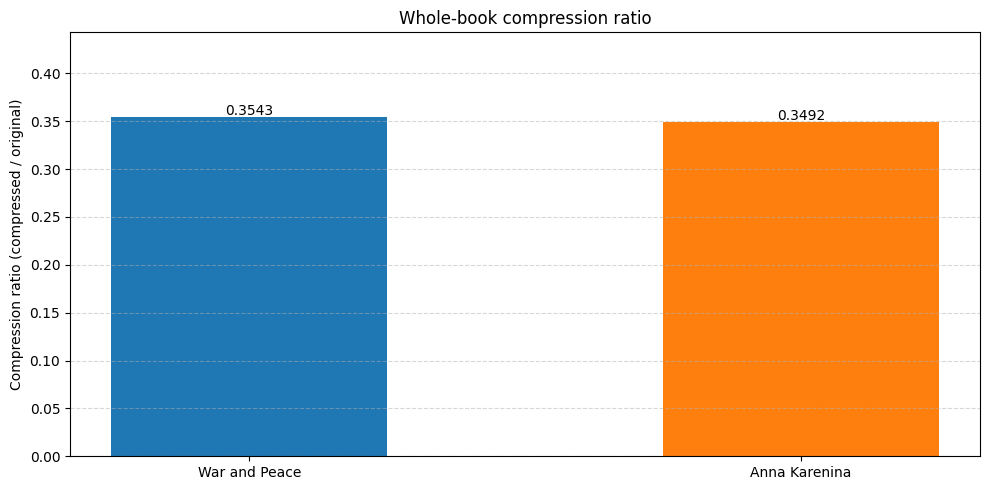

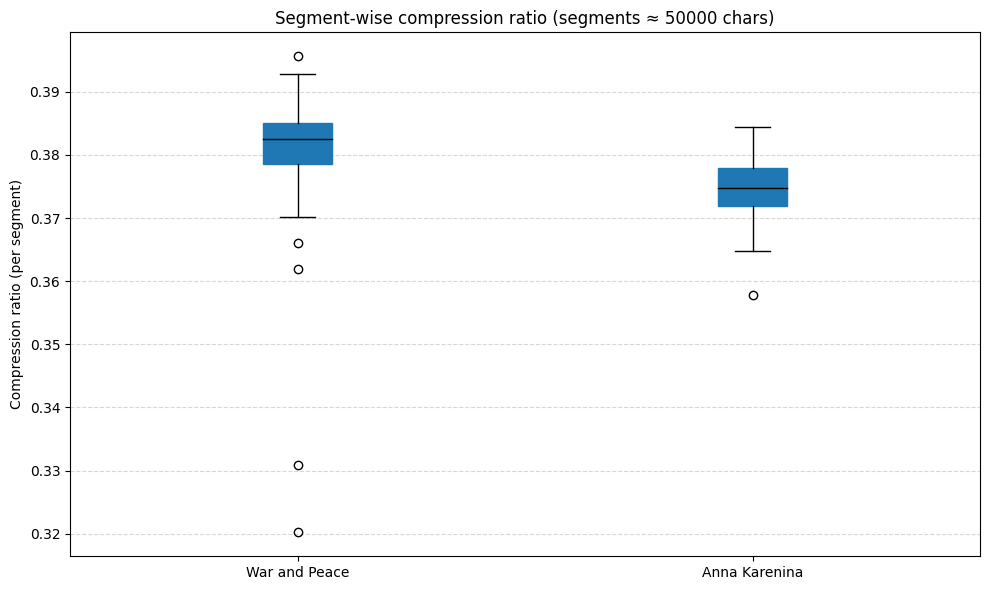

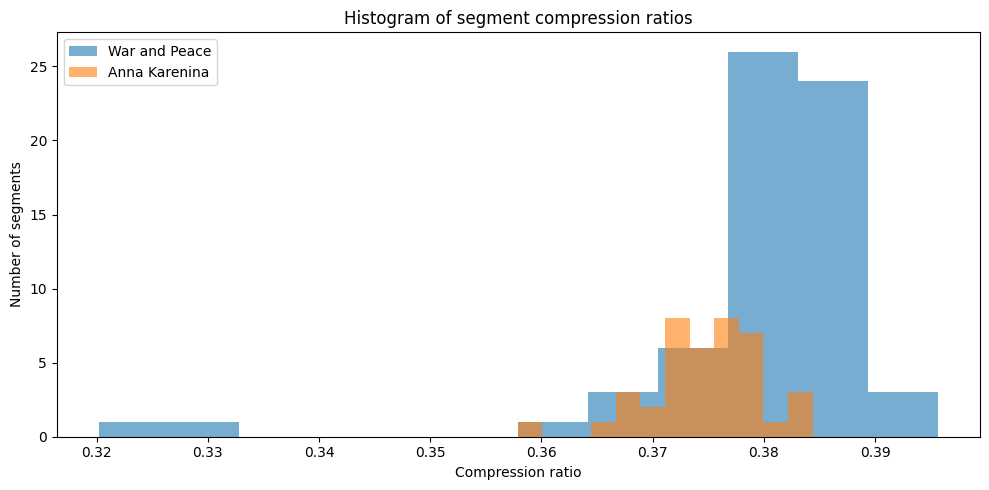

In [7]:
plt.figure(figsize=(10,5))
ax = plt.gca()

# Bar: whole-book compression ratios
books = ['War and Peace', 'Anna Karenina']
ratios = [war_ratio, anna_ratio]
bar_positions = np.arange(len(books))
bar_colors = ['#1f77b4', '#ff7f0e']
plt.bar(bar_positions, ratios, color=bar_colors, width=0.5)
plt.xticks(bar_positions, books)
plt.ylabel('Compression ratio (compressed / original)')
plt.title('Whole-book compression ratio')
for i, v in enumerate(ratios):
    plt.text(i, v + 0.002, f'{v:.4f}', ha='center')
plt.ylim(0, max(ratios) * 1.25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
bar_path = OUT_DIR / 'compression_ratio_bar.png'
plt.savefig(bar_path, dpi=150)
plt.show()

# Boxplot: segment-wise ratios side-by-side
plt.figure(figsize=(10,6))
data = [war_seg_ratios, anna_seg_ratios]
plt.boxplot(data, labels=books, patch_artist=True,
            boxprops=dict(facecolor='#1f77b4', color='#1f77b4'),
            medianprops=dict(color='black'))
plt.ylabel('Compression ratio (per segment)')
plt.title(f'Segment-wise compression ratio (segments ≈ {seg_size} chars)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
box_path = OUT_DIR / 'compression_ratio_boxplot.png'
plt.savefig(box_path, dpi=150)
plt.show()

# Histograms (overlay)
plt.figure(figsize=(10,5))
plt.hist(war_seg_ratios, bins=12, alpha=0.6, label='War and Peace')
plt.hist(anna_seg_ratios, bins=12, alpha=0.6, label='Anna Karenina')
plt.legend()
plt.xlabel('Compression ratio')
plt.ylabel('Number of segments')
plt.title('Histogram of segment compression ratios')
hist_path = OUT_DIR / 'compression_ratio_hist.png'
plt.tight_layout()
plt.savefig(hist_path, dpi=150)
plt.show()


In [8]:
results = {
    'basic': basic_results,
    'war_seg_ratios': war_seg_ratios,
    'anna_seg_ratios': anna_seg_ratios,
    'segment_size_chars': seg_size
}
out_file = OUT_DIR / 'compressibility_results.json'
with open(out_file, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2)
print('✅ Results saved to', out_file)
print('✅ Figures saved to', OUT_DIR)


✅ Results saved to C:\Users\Omen\Documents\GitHub\Fourth-Project\results\sentence_types\compressibility_results.json
✅ Figures saved to C:\Users\Omen\Documents\GitHub\Fourth-Project\results\sentence_types


## Interpretation / Notes

- **Compression ratio:** A lower compressed/original ratio indicates more redundancy and therefore higher compressibility.
- **NCD:** Normalized Compression Distance is a simple, domain-agnostic measure of similarity based on compression. Values closer to 0 indicate higher similarity; values closer to 1 indicate dissimilarity.
- **Segment distributions:** The boxplot and histograms show how compressibility varies across the book (different narrative sections may have different redundancy).

### Reproducibility tips
- If you want finer-grained analysis, reduce `segment_size_chars` (but that increases computation time).
- You can change the compression backend (e.g., gzip, lzma) by replacing `zlib.compress` with another compressor; NCD results may shift but relative patterns usually persist.


----
Notebook created programmatically. Run cells top-to-bottom. If you run into any missing packages, install them with `pip install matplotlib pandas nltk tqdm`.
